In [1]:
%%bash
nrnivmodl

/usr/bin/xcrun
/Users/anatolii-sorokin/Documents/Projects/neuron-model/mine
Mod files: "./h.mod" "./kadist.mod" "./kaprox.mod" "./kdrca1.mod" "./km.mod" "./na3n.mod" "./naxn.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special


In [2]:
# Download NEURON: http://www.neuron.yale.edu/neuron/download
# Download PyNeuronToolbox: https://github.com/ahwillia/PyNeuron-Toolbox

from neuron import h
import numpy as np
import pylab as plt
import scipy.linalg
from PyNeuronToolbox.record import ez_record,ez_convert
from PyNeuronToolbox.morphology import shapeplot,shapeplot_animate
from mpl_toolkits.mplot3d import Axes3D
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.pyplot import cm
%matplotlib inline
np.random.seed(123456789)

# Load morphology and other stuff
# --> SegLists: soma[2], dend[74], dend_5[37], apic[42], axon[1]
# --> Files from Migliore & Migliore (2012)
# --> CA1 pyramidal neuron
h.load_file('stdrun.hoc')
h.xopen('ri06.hoc')
h.xopen('fixnseg.hoc')
h.xopen('5a_nogui.hoc')
h.tstop = 700.0

	0 
total # of segments (50Hz): 742   max path distance: 853.32493 
apical 0  dend_5[0]
apical 1  dend_5[15]
apical 2  dend_5[14]
apical 3  dend_5[13]
apical 4  dend_5[12]
apical 5  dend_5[12]
apical 6  dend_5[12]
apical 7  dend_5[12]
apical 8  dend_5[12]
apical 9  dend_5[12]
apical 10  dend_5[12]
apical 11  dend_5[11]
apical 12  dend_5[11]
apical 13  dend_5[11]
apical 14  dend_5[10]
apical 15  dend_5[9]
apical 16  dend_5[8]
apical 17  dend_5[8]
apical 18  dend_5[8]
apical 19  dend_5[7]
apical 20  dend_5[6]
apical 21  dend_5[5]
apical 22  dend_5[5]
apical 23  dend_5[5]
apical 24  dend_5[5]
apical 25  dend_5[5]
apical 26  dend_5[5]
apical 27  dend_5[5]
apical 28  dend_5[4]
apical 29  dend_5[4]
apical 30  dend_5[4]
apical 31  dend_5[3]
apical 32  dend_5[2]
apical 33  dend_5[2]
apical 34  dend_5[2]
apical 35  dend_5[2]
apical 36  dend_5[2]
apical 37  dend_5[2]
apical 38  dend_5[2]
apical 39  dend_5[1]
apical 40  dend_5[1]
apical 41  dend_5[1]
#1


In [3]:
from PyNeuronToolbox.morphology import dist_between,allsec_preorder

def dist_to_soma(segment):
    return dist_between(h,h.soma[0](0.5),segment)

#seglist in pre-order
sec_list = allsec_preorder(h)
seg_list = []
for sec in sec_list:
    locs = np.linspace(0,1,sec.nseg+2)[1:-1]
    for loc in locs:
        seg_list.append(sec(loc))
n = len(seg_list)

In [4]:
for i in range(len(sec_list)):
    sec = sec_list[i]
    print(f"{i}: {sec.name()}, nseg={sec.nseg}, L={sec.L}, or={sec.orientation()}, hname={sec.hname()}")

0: soma[0], nseg=1, L=15.166100084781647, or=0.0, hname=soma[0]
1: soma[1], nseg=1, L=10.883900105953217, or=0.0, hname=soma[1]
2: dend_5[0], nseg=1, L=27.29313676464808, or=0.0, hname=dend_5[0]
3: apic[0], nseg=9, L=147.93433051396065, or=0.0, hname=apic[0]
4: dend_5[1], nseg=3, L=57.45149110486393, or=0.0, hname=dend_5[1]
5: apic[39], nseg=1, L=23.29171407802628, or=0.0, hname=apic[39]
6: apic[41], nseg=3, L=34.922839435595144, or=0.0, hname=apic[41]
7: apic[40], nseg=5, L=52.39168693889804, or=0.0, hname=apic[40]
8: dend_5[2], nseg=1, L=21.183727600433784, or=0.0, hname=dend_5[2]
9: apic[32], nseg=1, L=12.617619533060896, or=0.0, hname=apic[32]
10: apic[38], nseg=13, L=208.40219120020532, or=0.0, hname=apic[38]
11: apic[33], nseg=1, L=9.679981164937955, or=0.0, hname=apic[33]
12: apic[37], nseg=3, L=32.69642802210867, or=0.0, hname=apic[37]
13: apic[34], nseg=1, L=6.683028121429655, or=0.0, hname=apic[34]
14: apic[36], nseg=5, L=58.600785345533666, or=0.0, hname=apic[36]
15: apic[35

In [5]:
(dist_to_soma(sec(0)),dist_to_soma(sec(1)),sec.L,np.linspace(0,1,sec.nseg+2),np.linspace(0,1,sec.nseg+2)[1:-1])

(7.583050042390823,
 104.674267724172,
 97.09121768178117,
 array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
        0.83333333, 1.        ]),
 array([0.16666667, 0.33333333, 0.5       , 0.66666667, 0.83333333]))

In [6]:
dts = [dist_to_soma(s) for s in seg_list]
dts[:11]

[0.0,
 13.025000095367432,
 32.11351853066808,
 53.97866083043438,
 70.41580866531889,
 86.8529565002034,
 103.29010433508793,
 119.72725216997245,
 136.164400004857,
 152.60154783974147,
 169.03869567462598]

In [7]:
import re
import pandas as pd
p = re.compile("^([^\\[]+)\\[.+")
tps = [p.sub("\\1",seg.sec.name()) for seg in seg_list]
pd.Series(tps).drop_duplicates().tolist()

['soma', 'dend_5', 'apic', 'dend', 'axon']

In [8]:
seg = seg_list[0]
(seg.node_index(),seg.x,seg.sec)

(0, 0.5, soma[0])

In [9]:
(n,min(dts),max(dts))

(742, 0.0, 853.4184395306225)

In [10]:
def sushi_system(a,b,c,d):
    """
    Returns a matrix A, such that dx/dt = A*x
    
    N = # of compartments
    A is (2N x 2N) matrix
    x is (2N x 1) vector.
      The first N elements correspond to concentrations of u (molecules in transit)
      The second half correspond to concentrations of u-star (active molecules)
    The trafficking rate constants along the microtubules are given by the vectors "a" and "b"
    The rate constants for u turning into u* is given by the vector "c"
    The rate constants for the degradation of u* is given by the vector "d"
    """
    # number of compartments
    N = len(d)
    
    ## State-space equations
    #  dx/dt = Ax + Bu
    A = np.zeros((2*N,2*N))

    # Trafficking along belt
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            # Out of parent, into child
            ai = a.pop()
            A[p,p] += -ai
            A[i,p] += ai
            # Into parent, out of child
            bi = b.pop()
            A[p,i] += bi
            A[i,i] += -bi
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                # Out of parent, into child
                ai = a.pop()
                A[i-1,i-1] += -ai
                A[i,i-1] += ai
                # Into parent, out of child
                bi = b.pop()
                A[i-1,i] += bi
                A[i,i] += -bi
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # Trafficking off the belt
    for i in range(N):
        A[i,i] += -c[i]
        A[i+N,i] += c[i]

    # Degradation after being taken off the belt
    for i in range(N):
        A[i+N,i+N] = -d[i]
    
    return A

In [11]:
def trafficking_solution(utarg):
    """ Solve the problem by tuning trafficking rates, like Figs 1 and 2. """
    x = []
    
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            mp = utarg[p] # concentration in parent
            mc = utarg[i] # concentration in child
            x.insert(0,mp/mc)
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                mp = utarg[i-1]
                mc = utarg[i]
                x.insert(0,mp/mc)
                
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # return calculated guesses (flip, up/down since get_deriv pops from start)
    return np.array(x)

def get_sys_matrix(utarg,F=0.5,Ctau=1e-3,dv=1e-7):
    # F is a mixing factor between 0 and 1
    K = np.sum(utarg)/n
    x = trafficking_solution(F*utarg + (1-F)*K)
    a = (1/(1+x))
    a = list(a)
    b = list((1/(1+x**-1)))
    d = list(np.ones(n)*dv)
    c = list(Ctau*utarg/(F*utarg + (1-F)*K))
    A = sushi_system(a,b,c,d)
    return A

In [12]:
# matrix exponential used to solve linear system
from scipy.linalg import expm

# initial condition, u starts only in soma and is trafficked out to dendrites
u0 = np.zeros(2*n)
u0[0] = 1.0  # compartment 0 is the soma

In [13]:
utarg = np.ones(len(seg_list))
utarg[260:393] *= 10
utarg[393:] *= 0.1 # no trafficking to basal dend
utarg /= np.sum(utarg)
F=0.5
Ctau=1e-3
dv=1e-7
K = np.sum(utarg)/n
x = trafficking_solution(F*utarg + (1-F)*K)
a = (1/(1+x))
a = list(a)
b = list((1/(1+x**-1)))
d = list(np.ones(n)*dv)
c = list(Ctau*utarg/(F*utarg + (1-F)*K))
A = sushi_system(a,b,c,d)
(x.shape, A.shape[0]/2)

((741,), 742.0)

In [14]:
N = len(d)
An = np.zeros((2*N,2*N))
(N, len(a),len(b),len(c),An.shape,x.shape, (1/(1+x)).shape)

(742, 0, 0, 742, (1484, 1484), (741,), (741,))

In [15]:
a = (1/(1+x))
a = list(a)
aZ = []
(len(a),a.pop(),len(a),a.pop())

(741, 0.5, 740, 0.5)

In [16]:
def solve_u(w,V,Vinv,t):
    D = np.diag(np.exp(w*t))          # diagonal matrix exponential
    PHI = np.real(V.dot(D.dot(Vinv))) # state transition matrix
    return PHI.dot(u0)                # calculate u(t)

def run_sim(A,nframes=10):
    # Run a simulation (log time)
    # --> this is a linear system; thus, matrix exponential provides exact solution
    utrace = [u0]
    t = np.logspace(-0.5,8.5,nframes)
    w,V = scipy.linalg.eig(A)
    Vinv = np.linalg.inv(V)
    t = np.logspace(-0.5,8.5,nframes)
    for t_ in t: utrace.append(solve_u(w,V,Vinv,t_))
    return np.array(utrace).T

def animate_sim(climits=[0,0.0035]):
    u = utrace[n:,:]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('distribution of active/detached cargo',fontweight='bold',fontsize=14)
    plt.axis('off')

    # Hack to get a colorbar
    # http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(climits[0],climits[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm)
    plt.tight_layout()

    anim_func = shapeplot_animate(u.T,lines,u.shape[1],clim=climits,cmap=cm.cool)
    return animation.FuncAnimation(fig, anim_func, frames=u.shape[1], interval=5e2, blit=True)

def snap_ss(name,clim=[0,0.0035],cmap=plt.cm.cool):
    u = utrace[n:,:]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=u[:,-1],clim=clim,\
                      cmap=cmap,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('steady-state',fontweight='bold',fontsize=14)

    # colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(clim[0],clim[1])) 
    #sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm,cax=shapeax)
    #plt.colorbar()
    plt.tight_layout()
    plt.axis('off')
    plt.savefig(name+'.svg')

In [17]:
[int(i / 37) for i in range(n)]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,


In [18]:
utrace = [u0]
clr = [int(i / 37) for i in range(n)]
utrace.append(np.array(clr+clr))
utrace = np.array(utrace).T
utrace.shape

(1484, 2)

Text(0, 0.5, 'Segment group')

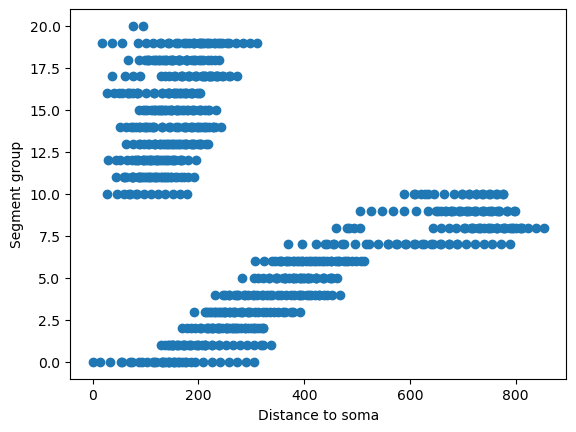

In [19]:
fig, ax = plt.subplots()
ax.scatter(dts,clr)
ax.set_xlabel('Distance to soma')
ax.set_ylabel('Segment group')

Read Experimental Data
----

In [20]:
tdf=pd.read_csv('seg_mapping.csv')
abbCA1=tdf['abb']
abbT={}
segIdx={}
for i in range(n):
    abbT[abbCA1[i]] = 1+ abbT.get(abbCA1[i],0)
    ll=segIdx.get(abbCA1[i],[])
    ll.append(i)
    segIdx[abbCA1[i]] = ll

(abbCA1,abbT,segIdx.keys(),{k:len(segIdx.get(k)) for k in segIdx.keys()})

(0          NaN
 1          NaN
 2      CA1sr_1
 3      CA1sr_1
 4      CA1sr_2
         ...   
 737        NaN
 738        NaN
 739        NaN
 740        NaN
 741        NaN
 Name: abb, Length: 742, dtype: object,
 {nan: 7,
  'CA1sr_1': 3,
  'CA1sr_2': 6,
  'CA1sr_3': 29,
  'CA1sr_4': 37,
  'CA1sr_5': 48,
  'CA1sr_6': 44,
  'CA1sr_7': 46,
  'CA1sr_8': 38,
  'CA1sr_9': 21,
  'CA1sr_10': 9,
  'CA1slm_1': 13,
  'CA1slm_2': 24,
  'CA1slm_3': 35,
  'CA1slm_4': 29,
  'CA1slm_5': 9,
  'CA1so_5': 16,
  'CA1so_4': 100,
  'CA1so_3': 134,
  'CA1so_2': 85,
  'CA1so_1': 9},
 dict_keys([nan, 'CA1sr_1', 'CA1sr_2', 'CA1sr_3', 'CA1sr_4', 'CA1sr_5', 'CA1sr_6', 'CA1sr_7', 'CA1sr_8', 'CA1sr_9', 'CA1sr_10', 'CA1slm_1', 'CA1slm_2', 'CA1slm_3', 'CA1slm_4', 'CA1slm_5', 'CA1so_5', 'CA1so_4', 'CA1so_3', 'CA1so_2', 'CA1so_1']),
 {nan: 7,
  'CA1sr_1': 3,
  'CA1sr_2': 6,
  'CA1sr_3': 29,
  'CA1sr_4': 37,
  'CA1sr_5': 48,
  'CA1sr_6': 44,
  'CA1sr_7': 46,
  'CA1sr_8': 38,
  'CA1sr_9': 21,
  'CA1sr_10': 9,
  'CA1s

In [21]:
expD=pd.read_csv('data/CA1_gradient.csv')
expD

,Abbreviation,Subregion,D0W3_MEAN,D0W3_SD,D7W3_MEAN,D7W3_SD,D0M3_MEAN,D0M3_SD,D7M3_MEAN,D7M3_SD,D0M18_MEAN,D0M18_SD,D7M18_MEAN,D7M18_SD
0,CA1so_1,CA1so,57.666667,14.497175,2.306667,3.262119,58.820000,7.474454,25.373333,4.315378,68.046667,6.524239,29.986667,1.631060
1,CA1so_2,CA1so,89.960000,12.946135,5.766667,8.155298,87.653333,8.155298,44.980000,2.825078,94.573333,1.631060,51.900000,5.650156
2,CA1so_3,CA1so,100.340000,14.948909,6.920000,9.786358,96.880000,9.786358,51.900000,4.893179,101.493333,3.262119,57.666667,7.109624
3,CA1so_4,CA1so,99.186667,14.497175,5.766667,8.155298,96.880000,9.786358,46.133333,7.109624,103.800000,2.825078,53.053333,8.630756
4,CA1so_5,CA1so,83.040000,17.642608,2.306667,3.262119,87.653333,10.695573,28.833333,7.109624,98.033333,3.262119,32.293333,9.921348
5,CA1sr_1,CA1sr,70.353333,10.695573,3.460000,4.893179,69.200000,7.474454,29.986667,3.262119,74.966667,3.262119,36.906667,4.315378
6,CA1sr_2,CA1sr,89.383333,12.341206,5.766667,8.155298,80.733333,8.155298,36.906667,5.880869,85.346667,1.631060,42.673333,5.880869
7,CA1sr_3,CA1sr,94.573333,13.350799,6.920000,9.786358,84.193333,10.695573,40.943333,5.708709,88.806667,1.631060,48.440000,4.893179
8,CA1sr_4,CA1sr,95.726667,11.761738,8.073333,11.417417,85.346667,9.081356,44.980000,4.893179,88.806667,4.315378,53.053333,5.880869
9,CA1sr_5,CA1sr,94.573333,10.695573,9.226667,13.048477,84.193333,8.155298,47.286667,5.880869,87.653333,4.315378,55.360000,5.650156


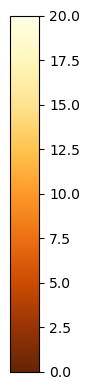

In [22]:
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrBr_r, norm=plt.Normalize(0,20)) 
#plt.colorbar(sm)
fig, ax = plt.subplots(figsize=(1, 4))
# vmin, vmax =  np.nanmin(A), np.nanmax(A)
cbar = fig.colorbar(sm, ax)
plt.tight_layout()
plt.show()

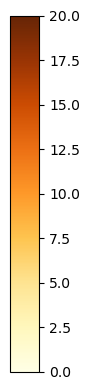

In [23]:
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrBr, norm=plt.Normalize(0,20)) 
#plt.colorbar(sm)
fig, ax = plt.subplots(figsize=(1, 4))
# vmin, vmax =  np.nanmin(A), np.nanmax(A)
cbar = fig.colorbar(sm, ax)
plt.tight_layout()
plt.show()

In [24]:
import sushi
import time

First Case: timescales separated ($c_i$ small), little interference/competition
-----
Day 0 3 weeks
----

101.4933333

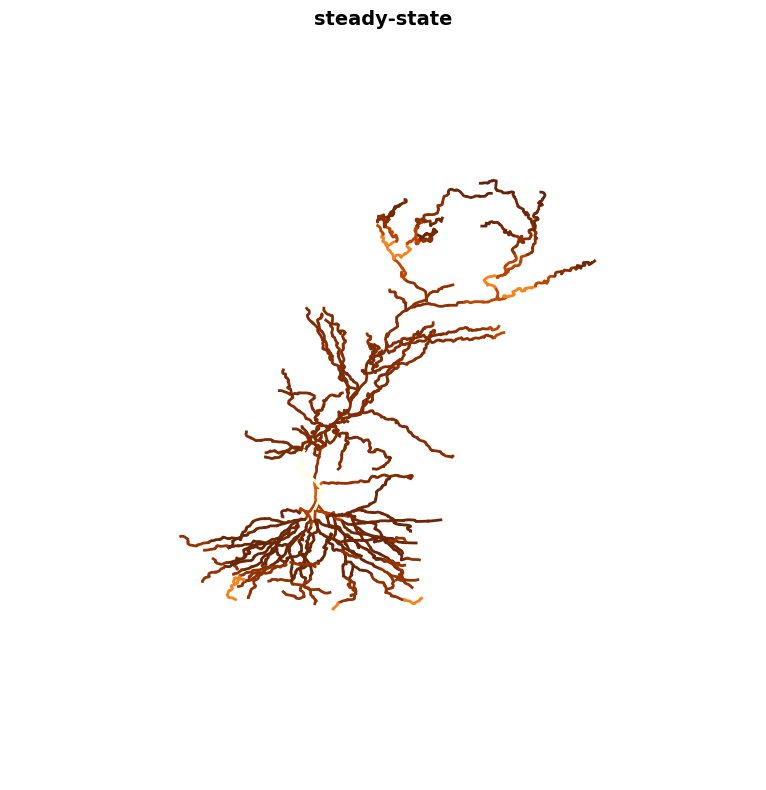

In [25]:
cname='D0W3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case1_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

17.181986093521118


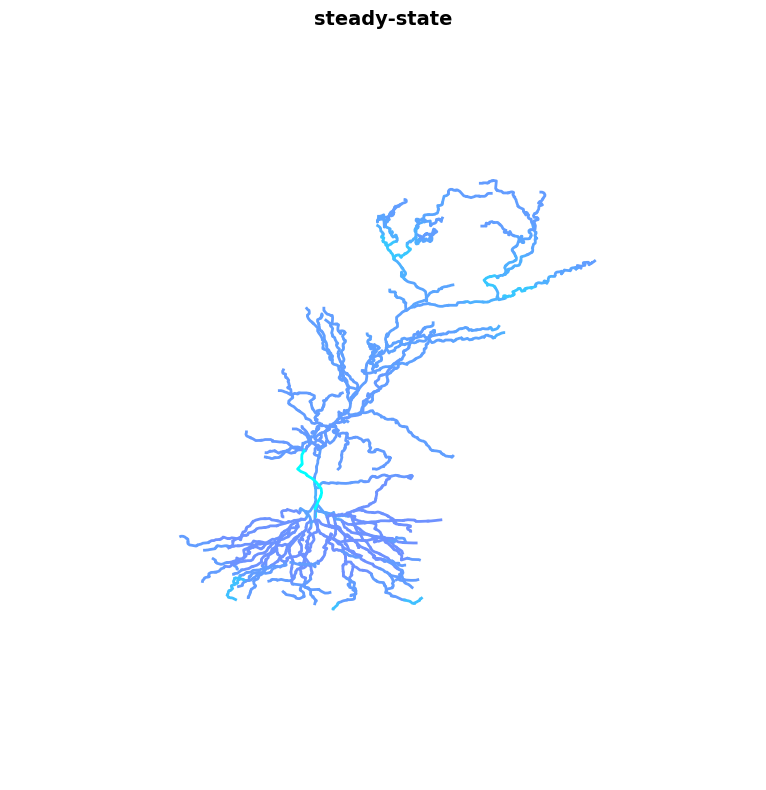

In [26]:
# Run simulation
utarg /= np.sum(utarg)
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=1e-5,dv=0)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case1_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 3 weeks
----

19.60666667

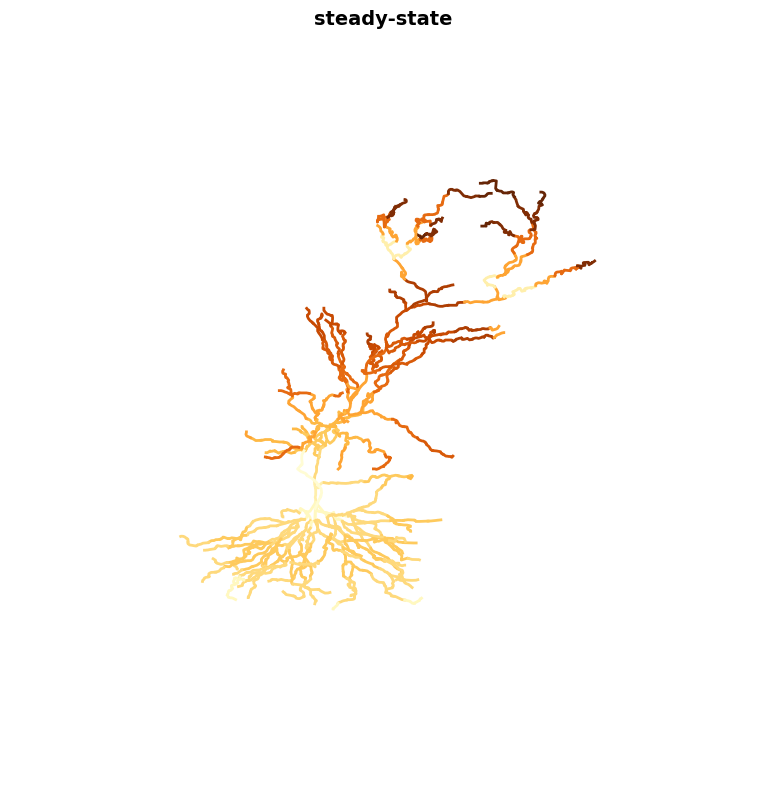

In [27]:
cname='D7W3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case1_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

14.374009847640991


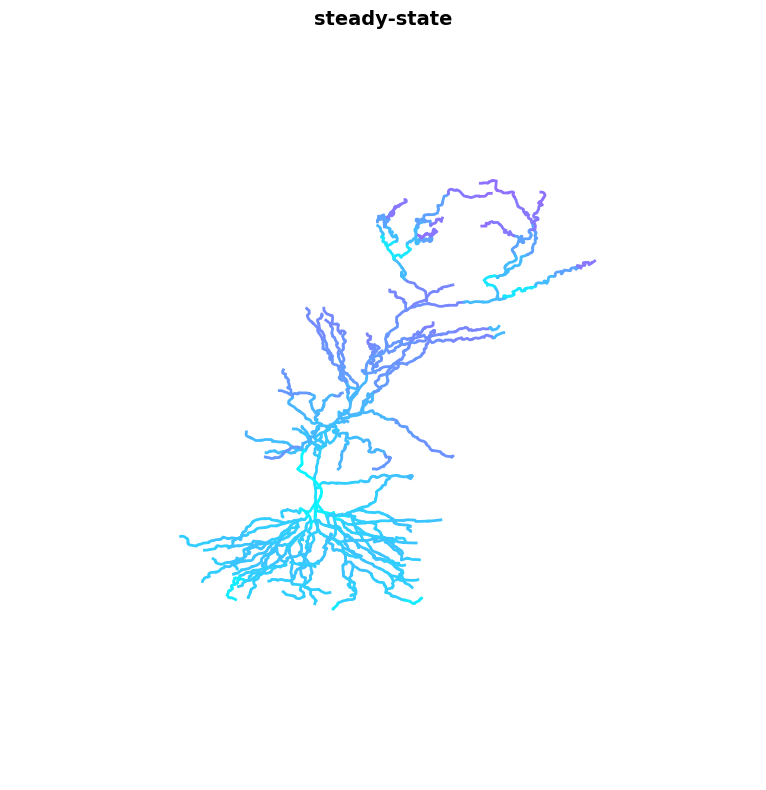

In [28]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=1e-5,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case1_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 0 3 month
----

96.88

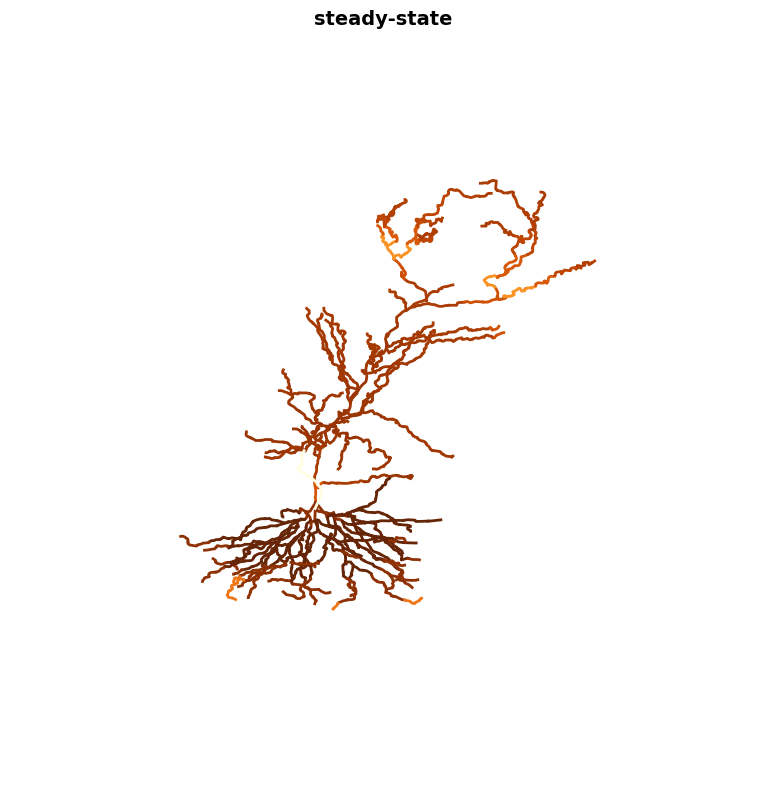

In [29]:
cname='D0M3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case1_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

12.33612322807312


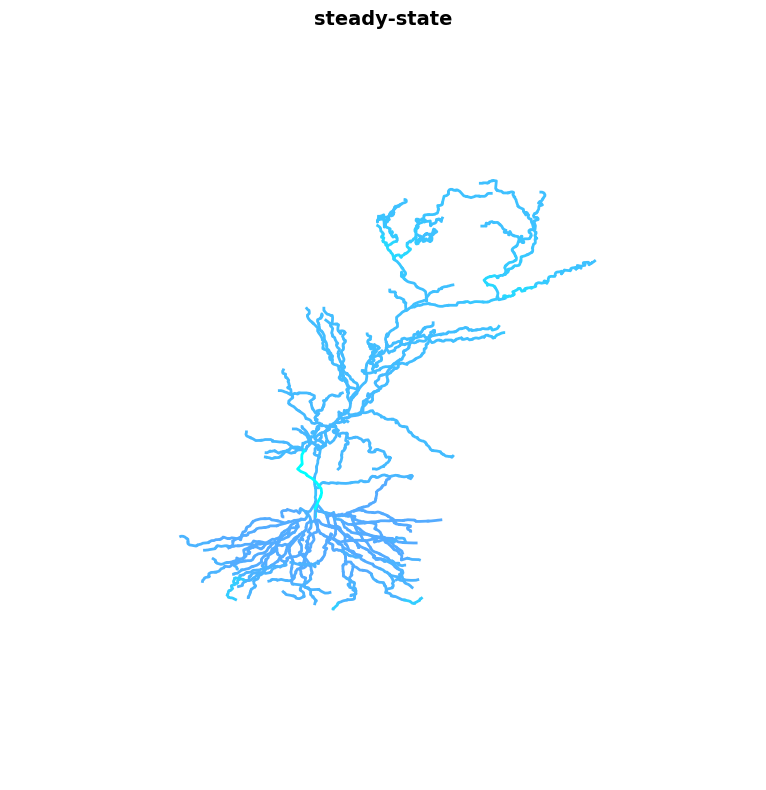

In [30]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=1e-5,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case1_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 3 month
----

54.20666667

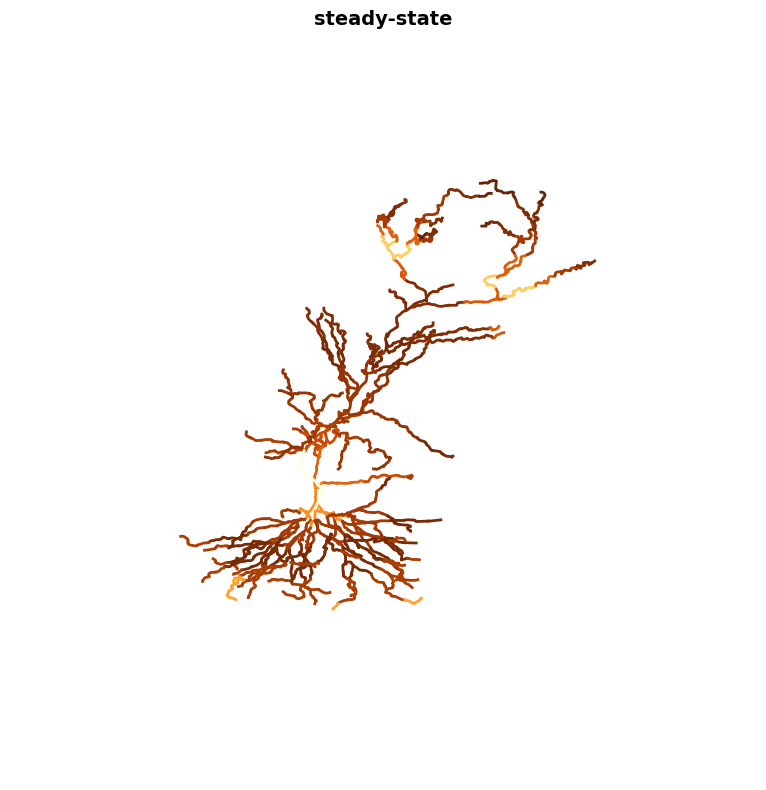

In [31]:
cname='D7M3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case1_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

13.607978105545044


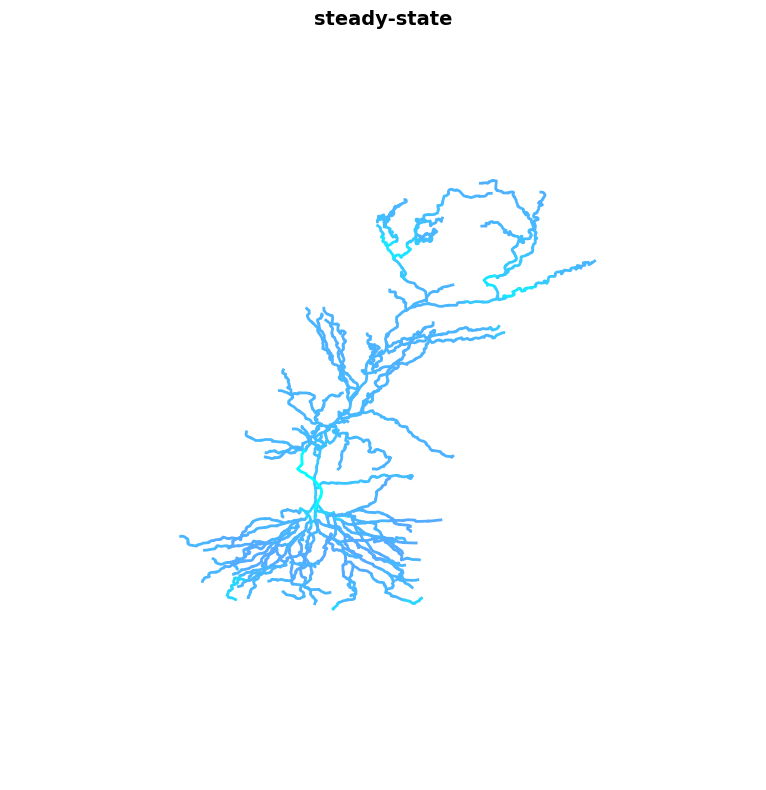

In [32]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=1e-5,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case1_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 0 18 month
----

103.8

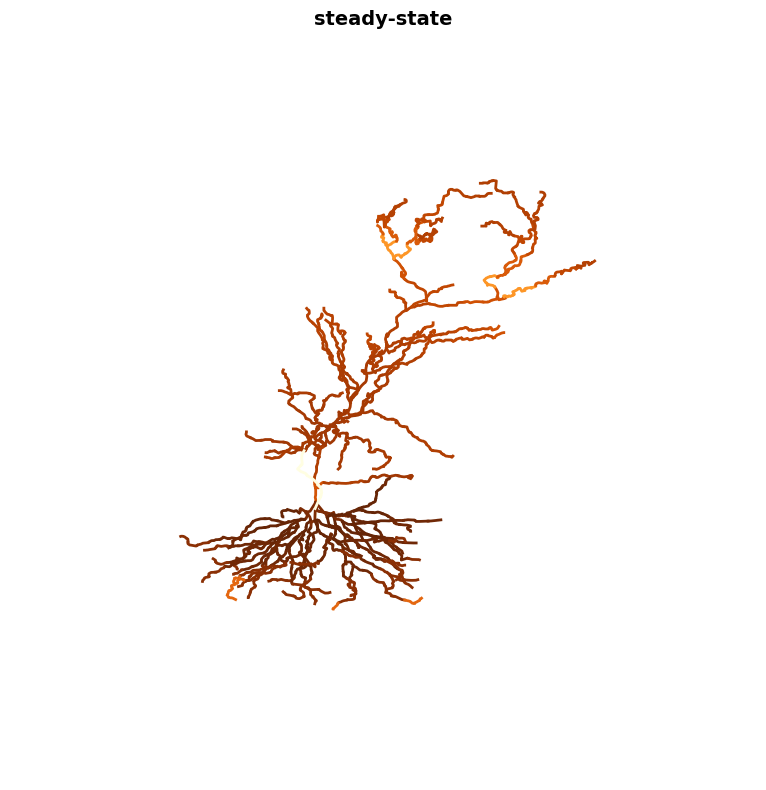

In [33]:
cname='D0M18'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case1_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

11.32509732246399


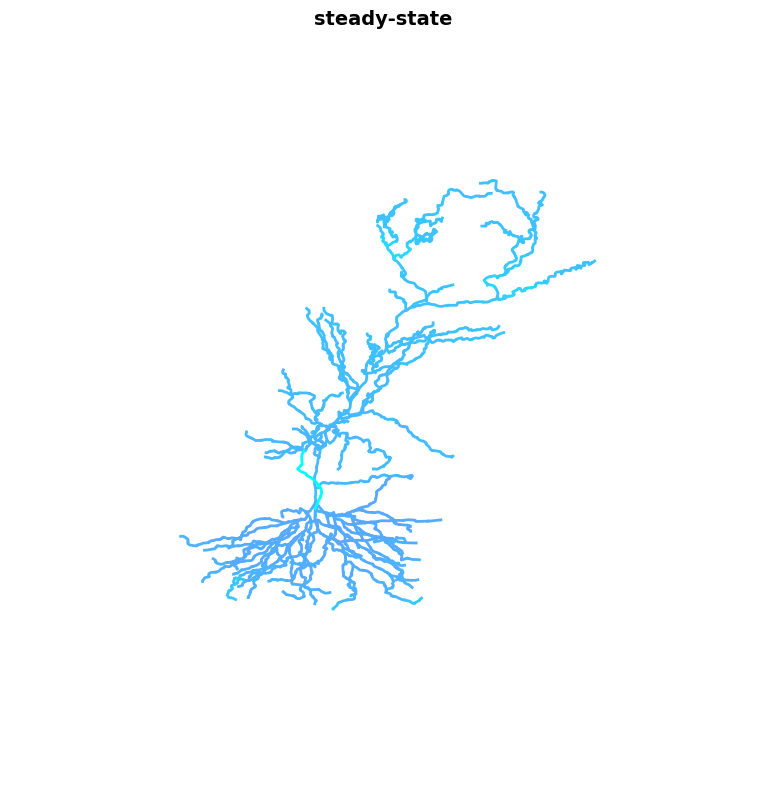

In [34]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=1e-5,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case1_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 18 month
----

61.12666667

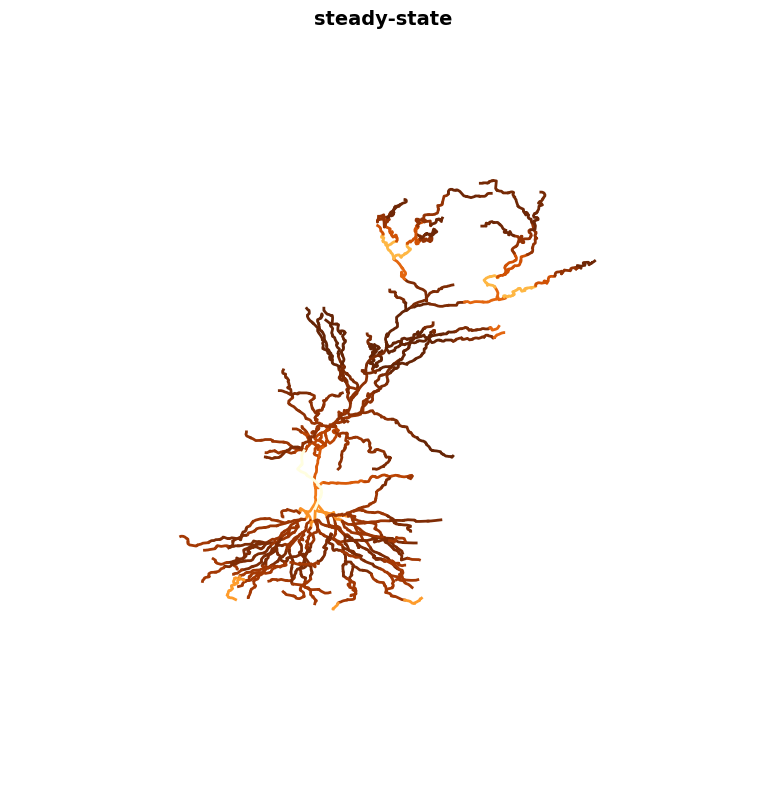

In [35]:
cname='D7M18'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case1_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

10.1525239944458


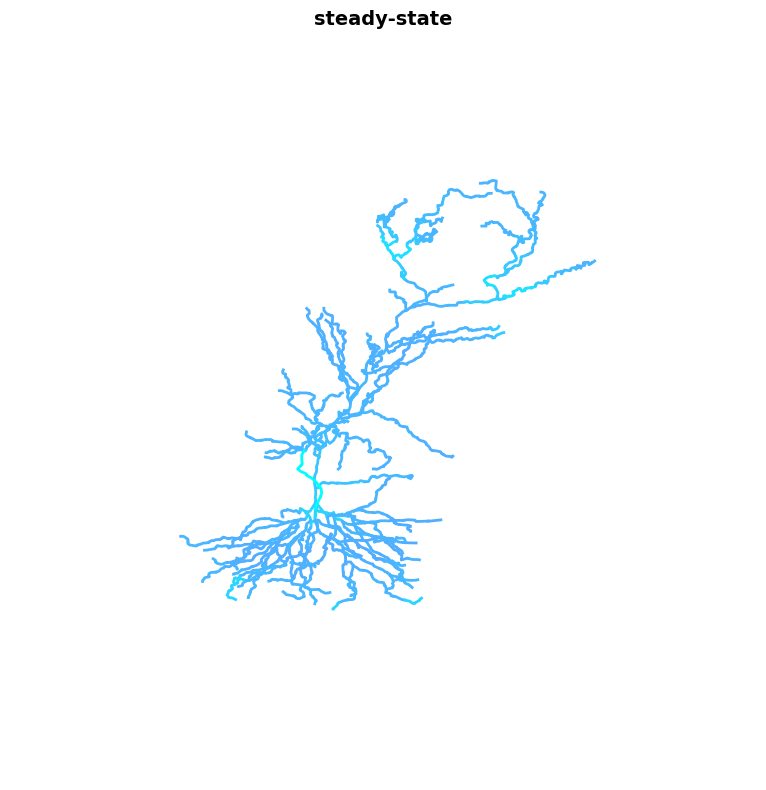

In [36]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=1e-5,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case1_{cname}")

# animation
#animate_sim()
print(FinalTime)

Second Case: timescales not separated, proximal inputs are *greedy* and prevent distal transport
----

Day 0 3 weeks
----

101.4933333

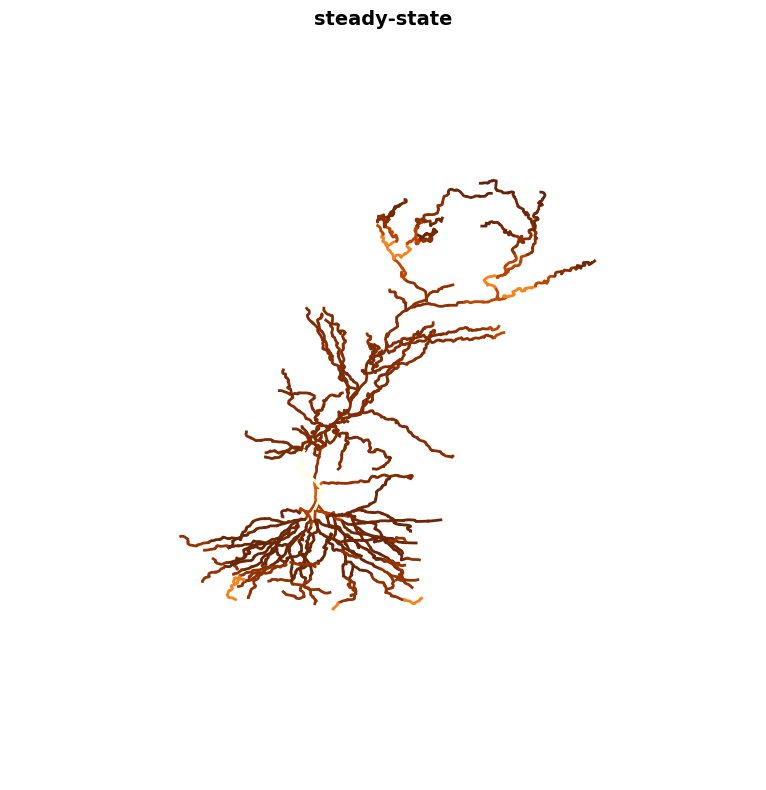

In [37]:
cname='D0W3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case2_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

9.755995035171509


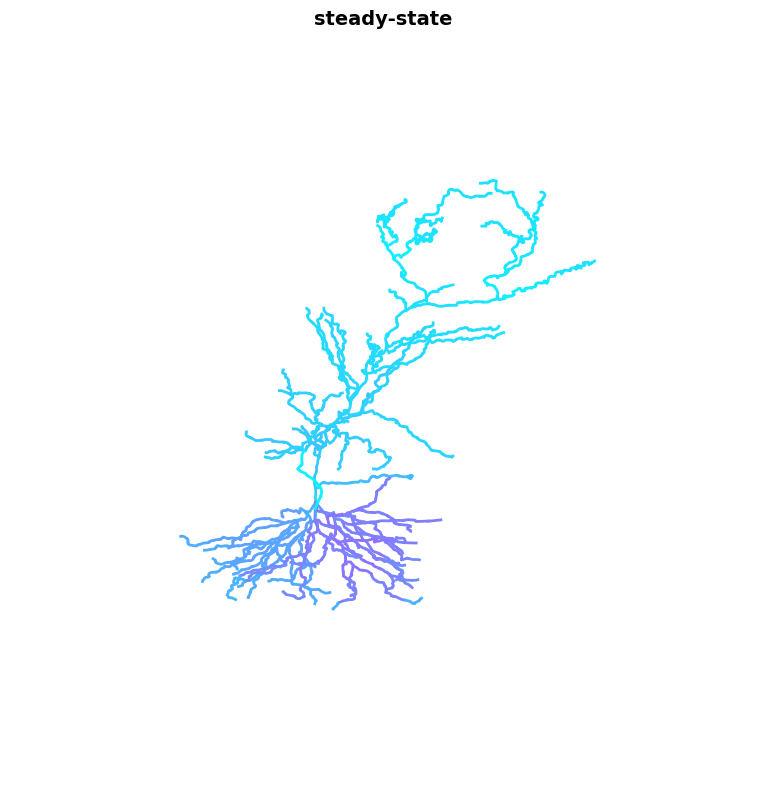

In [38]:
# Run simulation
utarg /= np.sum(utarg)
initTime=time.time()
A = get_sys_matrix(utarg,F=1,Ctau=1e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case2_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 3 weeks
----

19.60666667

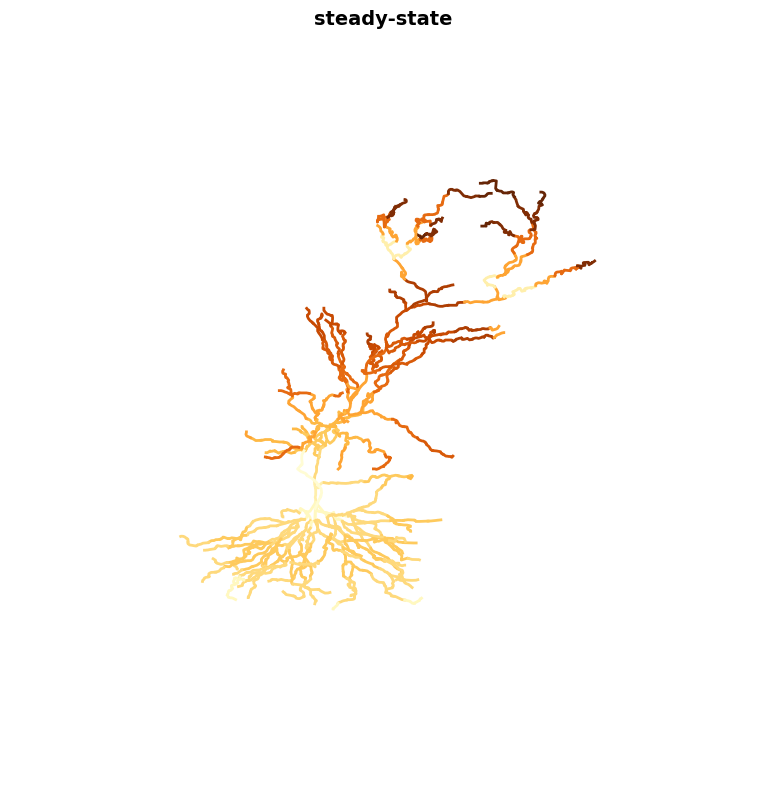

In [39]:
cname='D7W3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case2_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

9.870090961456299


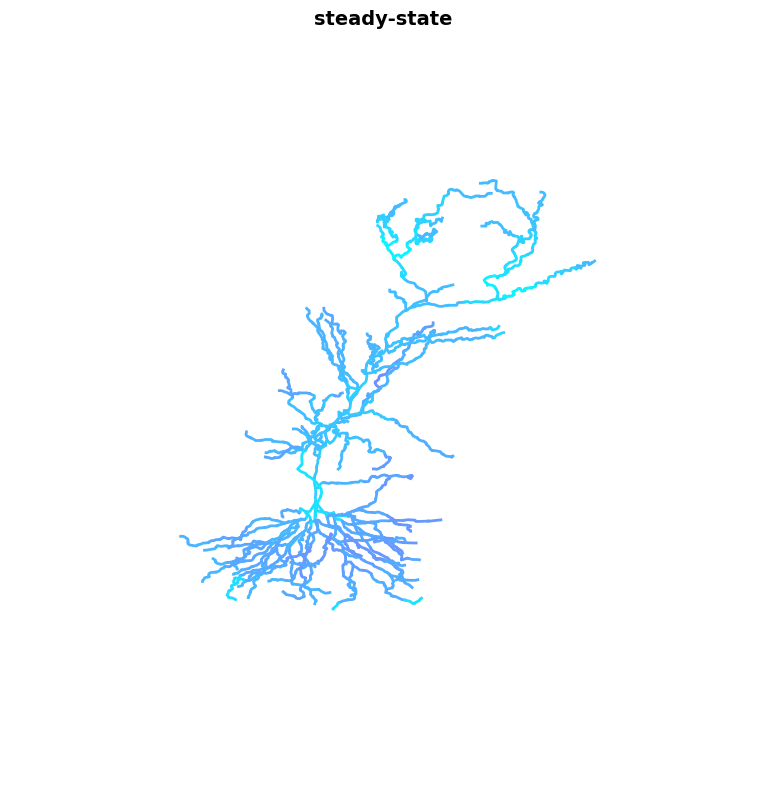

In [40]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=1,Ctau=1e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case2_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 0 3 month
----

96.88

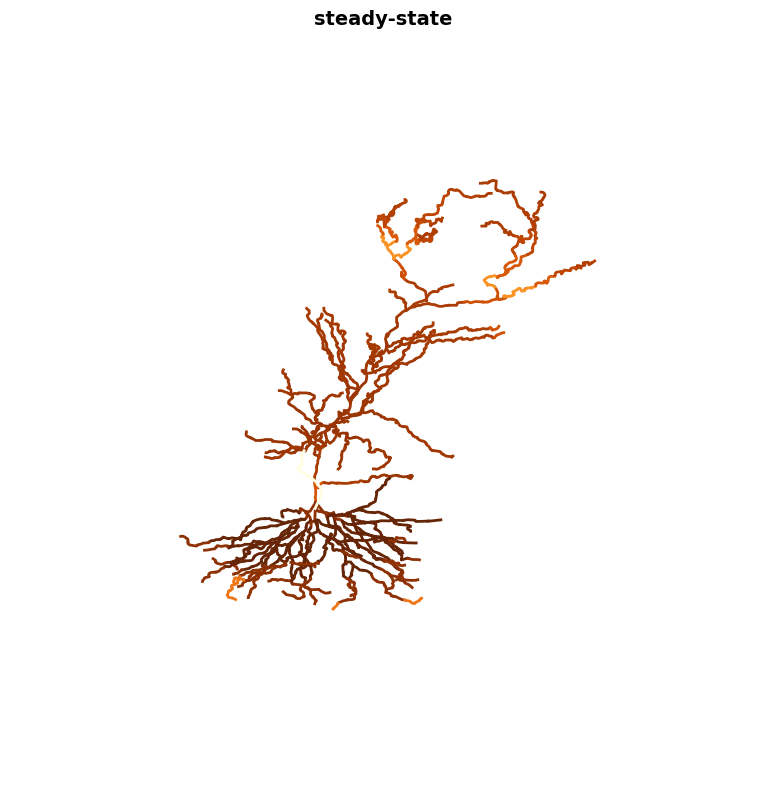

In [41]:
cname='D0M3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case2_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

10.42413592338562


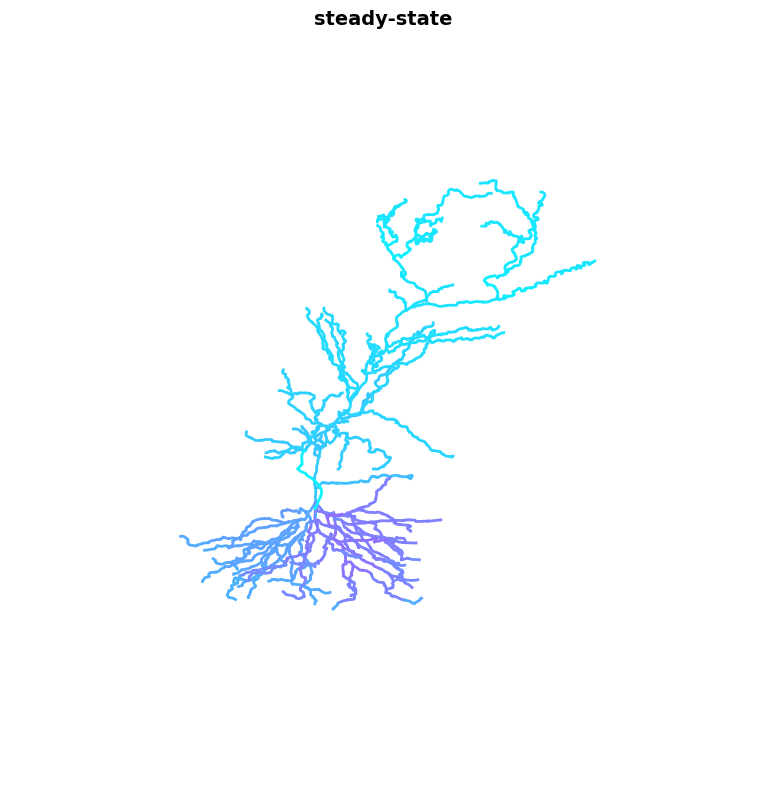

In [42]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=1,Ctau=1e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case2_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 3 month
----

54.20666667

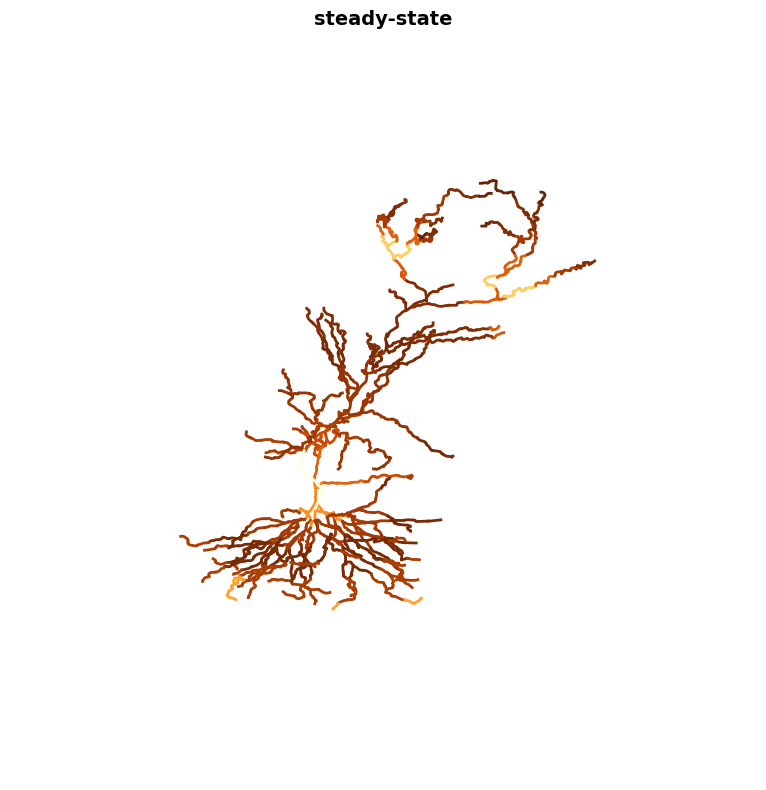

In [43]:
cname='D7M3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case2_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

10.411632776260376


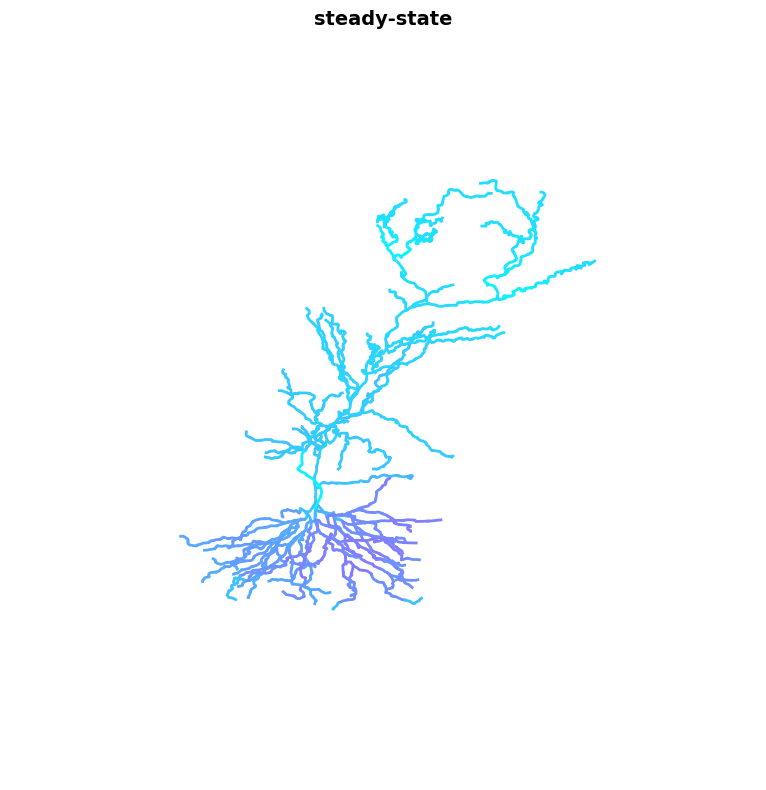

In [44]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=1,Ctau=1e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case2_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 0 18 month
----

103.8

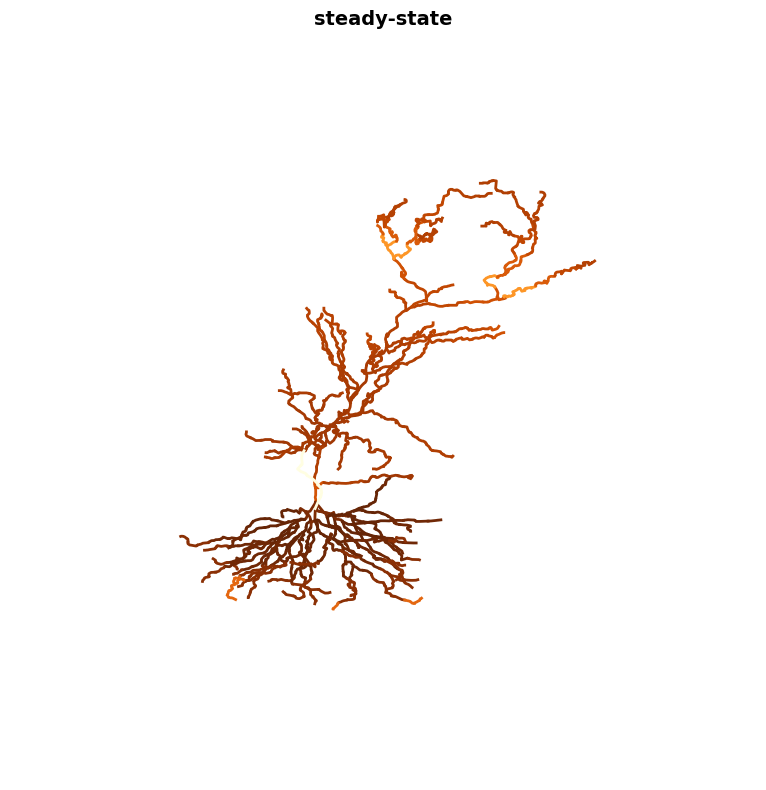

In [45]:
cname='D0M18'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case2_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

10.2166588306427


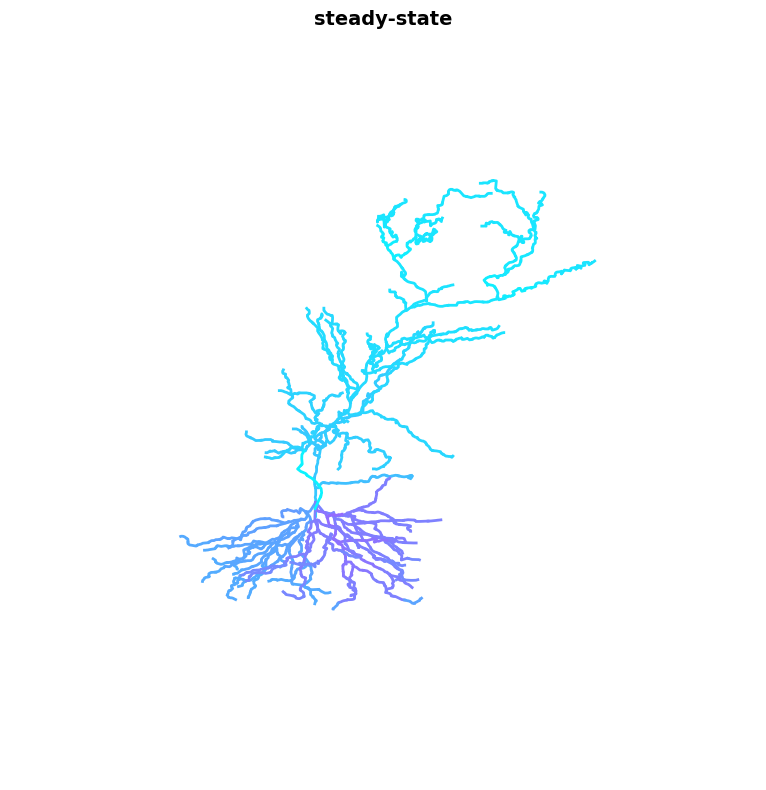

In [46]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=1,Ctau=1e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case2_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 18 month
----

61.12666667

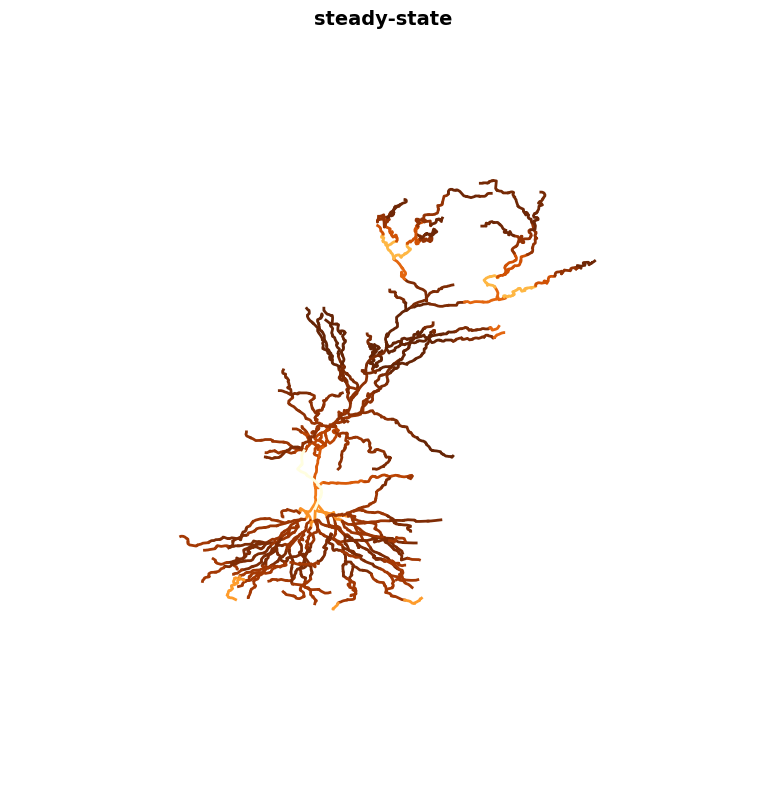

In [47]:
cname='D7M18'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case2_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

10.066076755523682


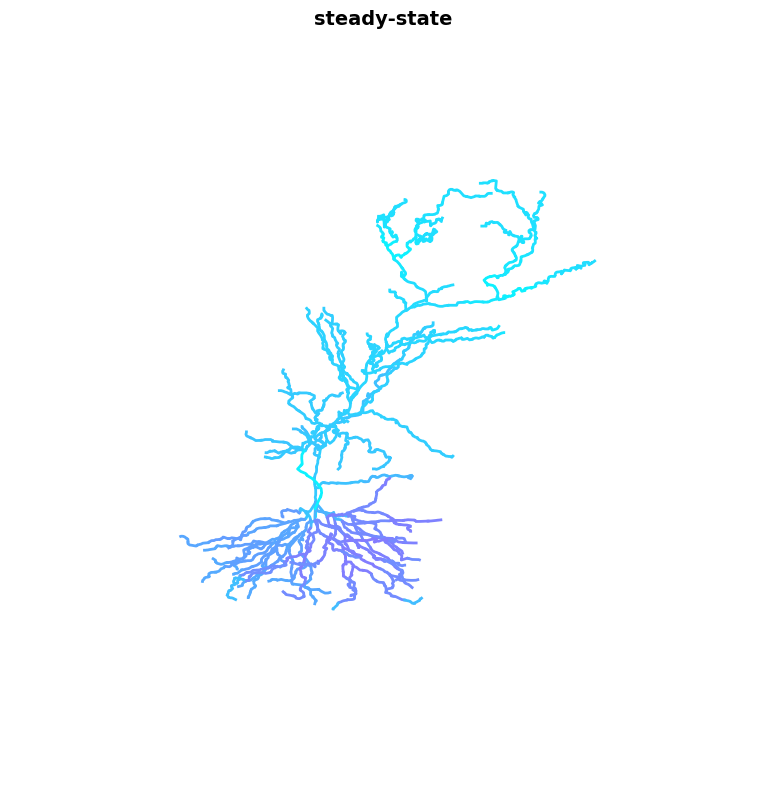

In [48]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=1,Ctau=1e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case2_{cname}")

# animation
#animate_sim()
print(FinalTime)

Third Case: Time scales separated, different trafficking strategy
------

Day 0 3 weeks
----

101.4933333

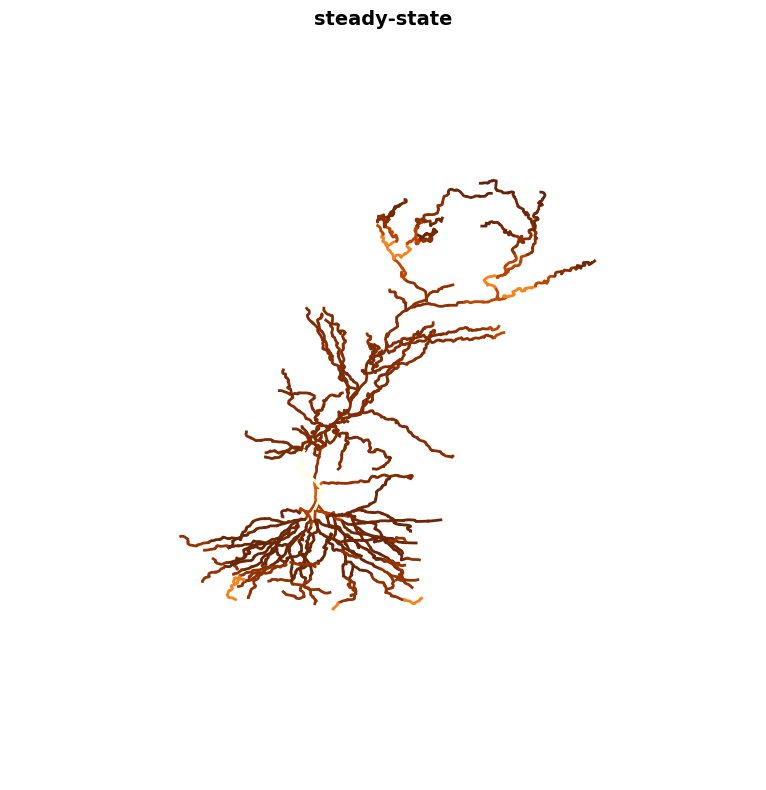

In [49]:
cname='D0W3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case3_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

12.7236967086792


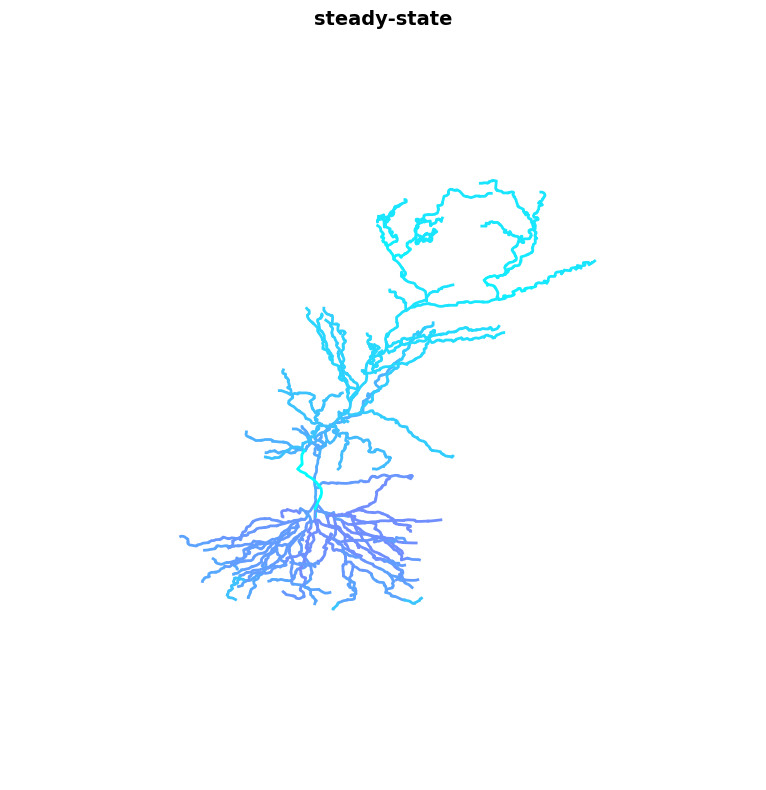

In [50]:
# Run simulation
utarg /= np.sum(utarg)
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=2e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case3_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 3 weeks
----

19.60666667

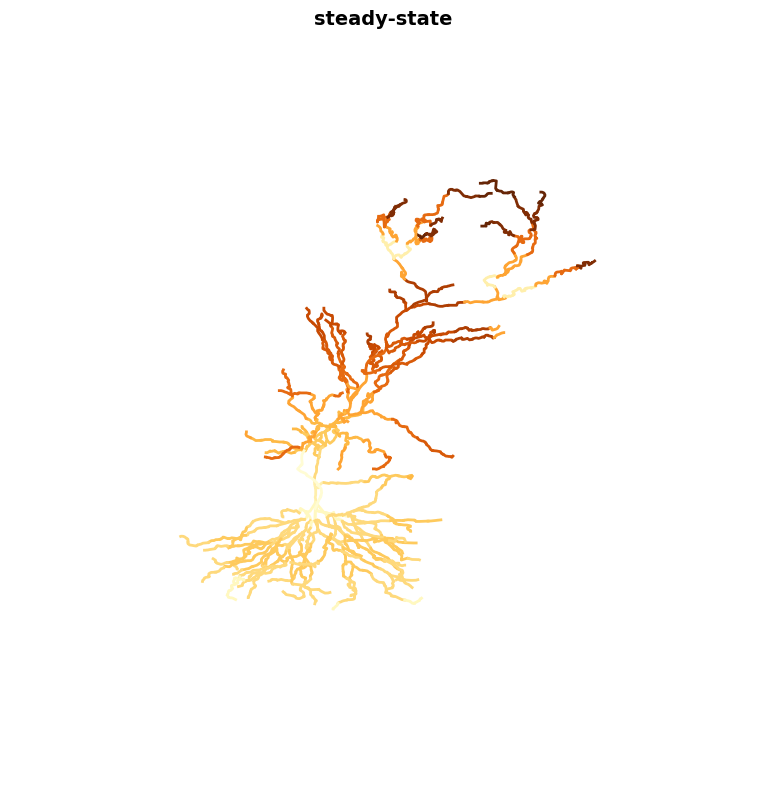

In [51]:
cname='D7W3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case3_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

11.720909118652344


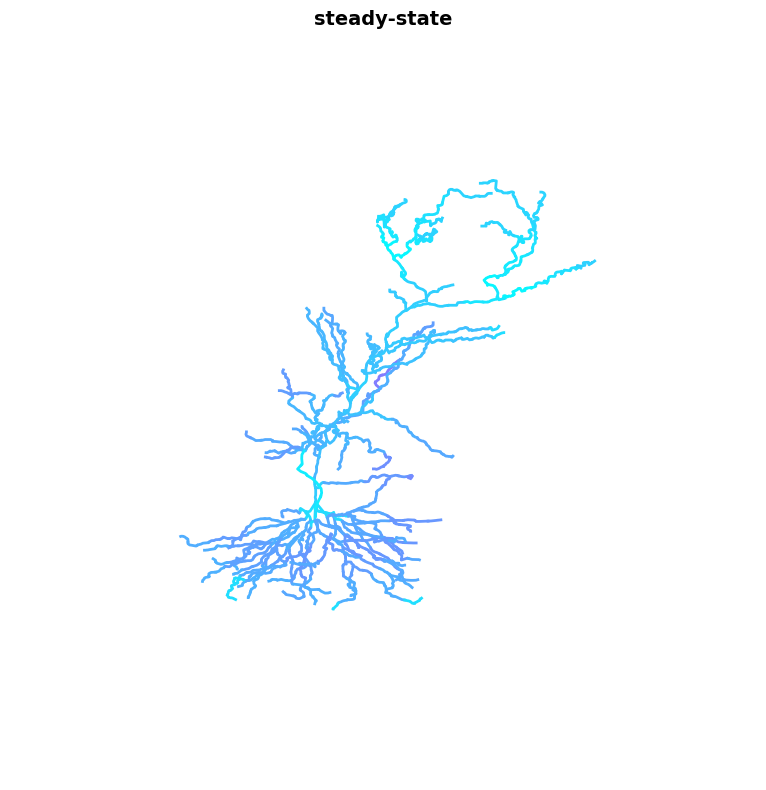

In [52]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=2e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case3_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 0 3 month
----

96.88

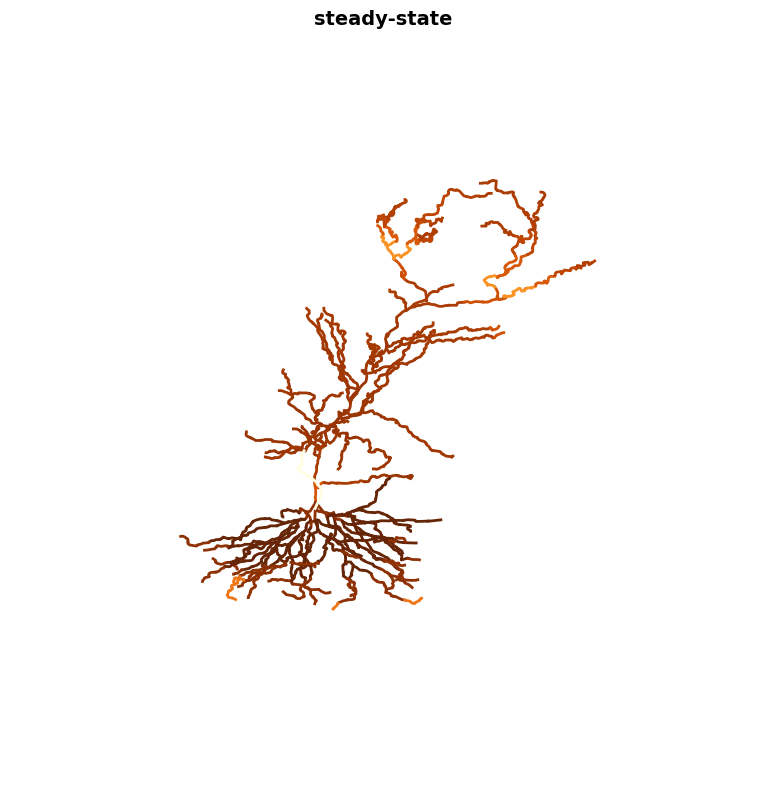

In [53]:
cname='D0M3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case3_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

10.038860082626343


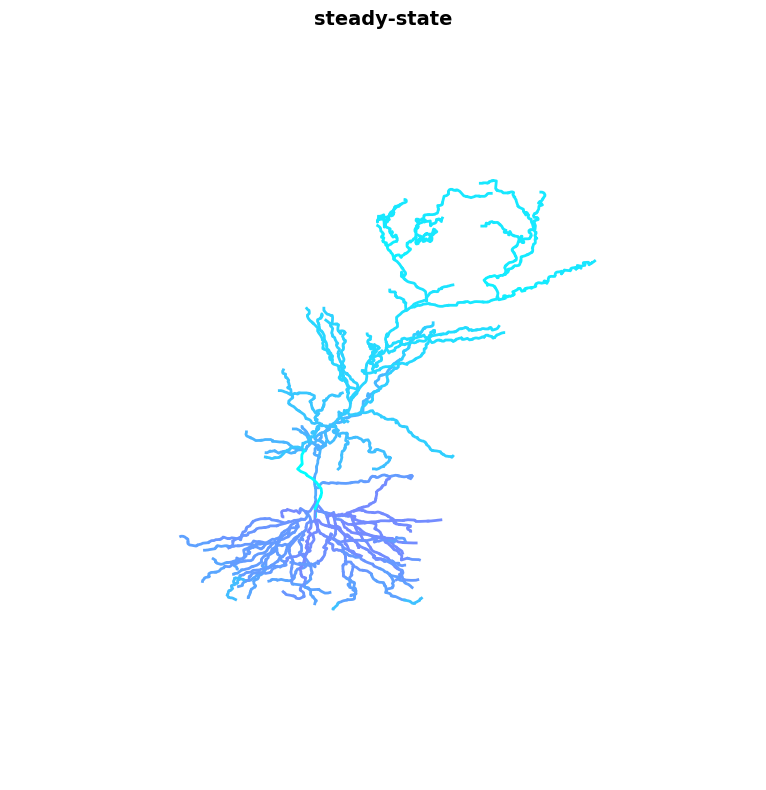

In [54]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=2e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case3_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 3 month
----

54.20666667

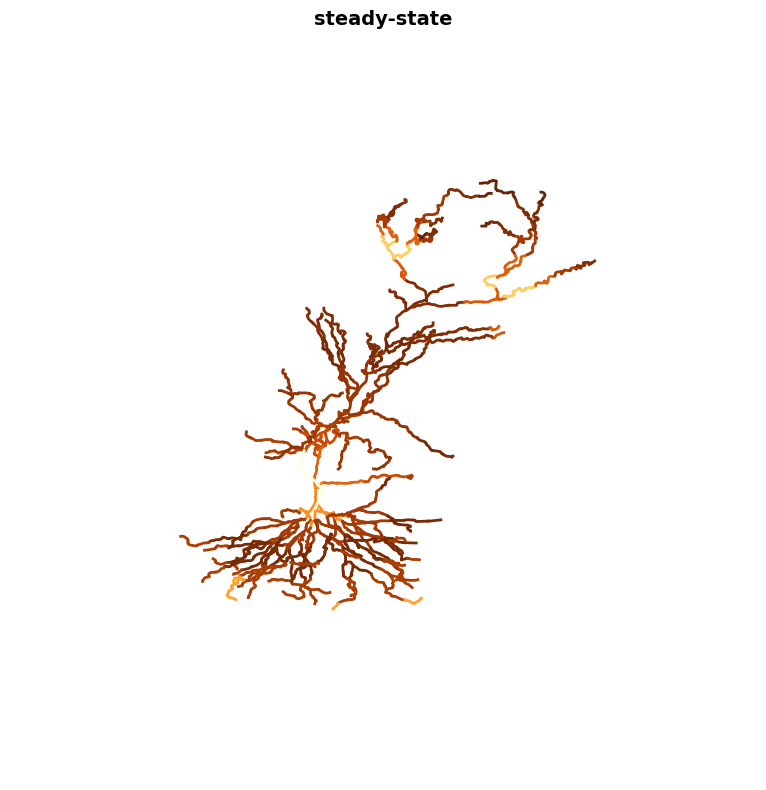

In [55]:
cname='D7M3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case3_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

11.477054119110107


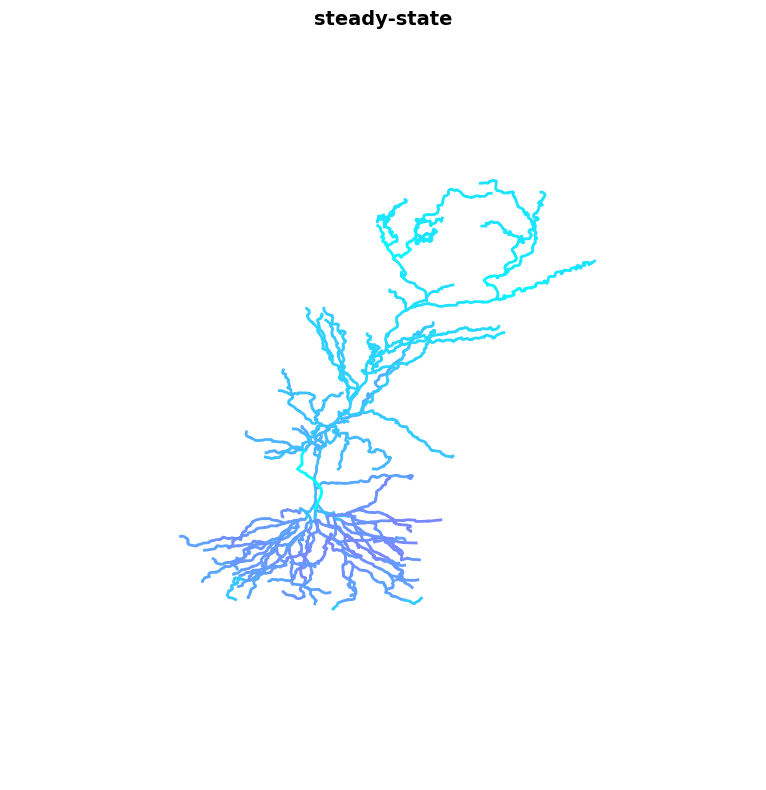

In [56]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=2e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case3_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 0 18 month
----

103.8

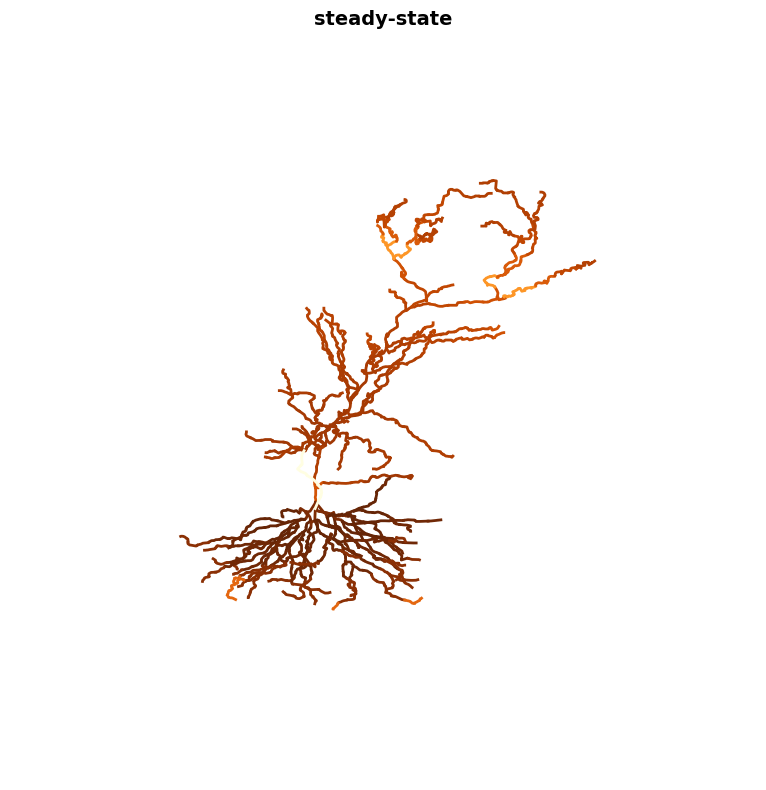

In [57]:
cname='D0M18'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case3_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

10.30905294418335


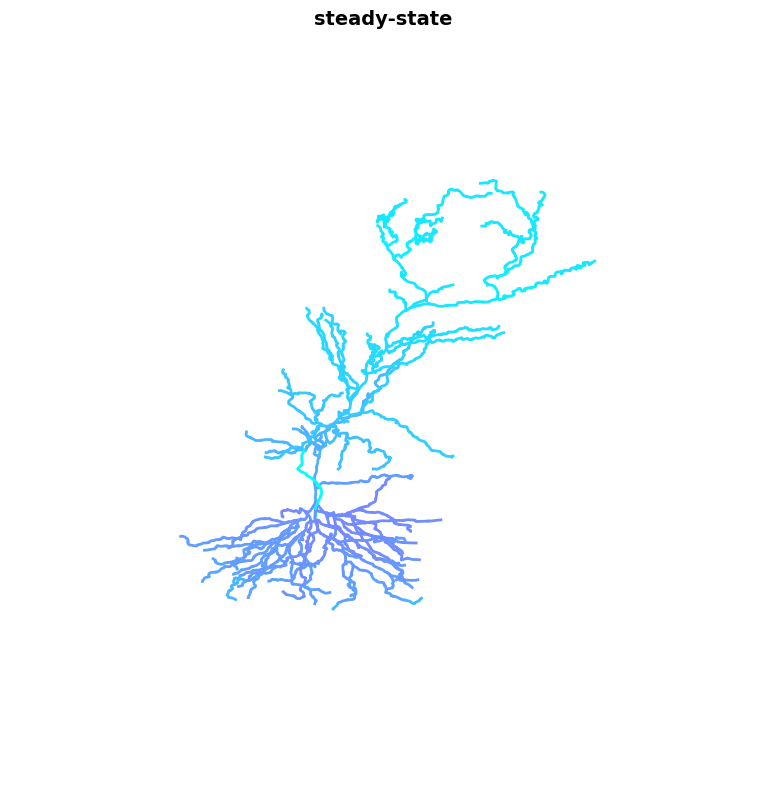

In [58]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=2e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case3_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 18 month
----

61.12666667

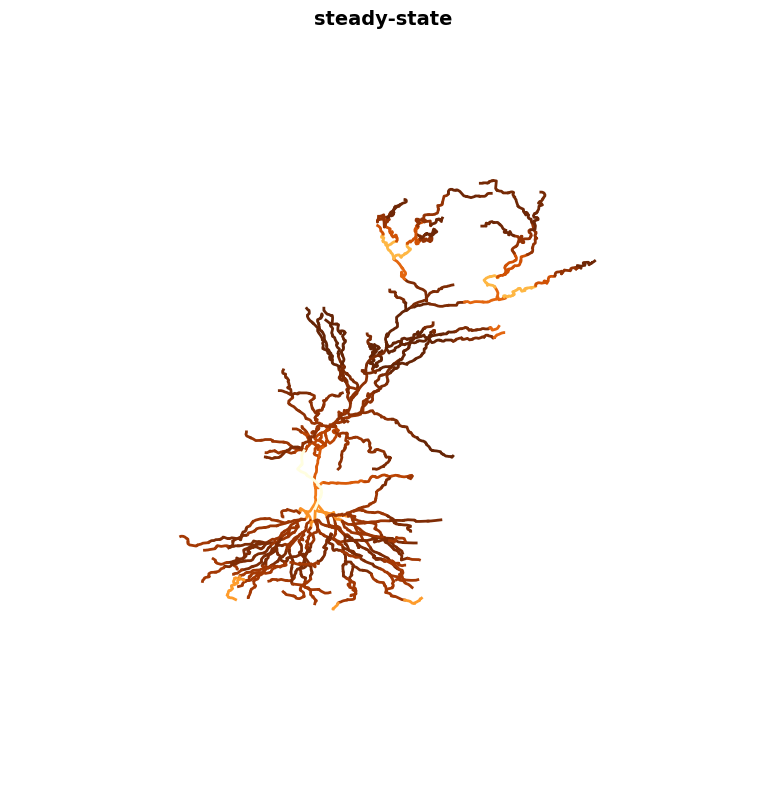

In [59]:
cname='D7M18'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case3_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

12.747004747390747


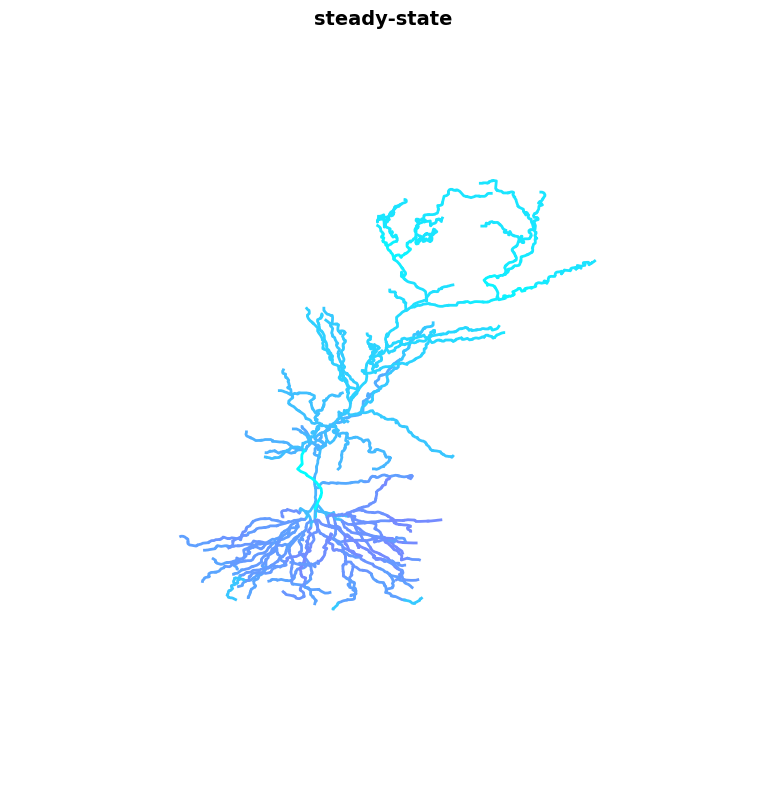

In [60]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=2e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case3_{cname}")

# animation
#animate_sim()
print(FinalTime)

In [61]:
utrace[743:753,10]

array([2.97619411e-05, 1.02842644e-03, 1.02527754e-03, 1.18216541e-03,
       1.17923318e-03, 1.17667953e-03, 1.33322035e-03, 1.33123628e-03,
       1.32973735e-03, 1.32872301e-03])

Third Case: protein + RNA
----

In [ ]:
initTime=time.time()
A,u,t,excess,err = sushi.run_uniform_reattachment(h, 0.1, 5, 50.0, 1e-5,1e-6)
FinalTime=time.time()-initTime
print(FinalTime)
#sushi.snapshots(h,u,t,'plots/with_reattach',cellname,view,u_cmap,us_cmap)
#print 'excess cargo = %2.1f percent'%(excess[-1])

In [ ]:
N
utrace=u[:,:2*N]
utrace=utrace.T

In [ ]:
A.shape

In [ ]:
t.shape

In [ ]:
u.shape

In [ ]:
nframes=50
t = np.logspace(-0.5,8.5,nframes)
t.shape

In [ ]:
u0 = np.zeros(4*n)
u0[0] = 1.0  # compartment 0 is the soma
initTime=time.time()
utrace = [u0]
w,V = scipy.linalg.eig(A)
Vinv = np.linalg.inv(V)
t = np.logspace(-0.5,8.5,nframes)
for t_ in t: utrace.append(solve_u(w,V,Vinv,t_))

FinalTime=time.time()-initTime
print(FinalTime)


cvals=utrace[:,-1]
cvals.shape

In [ ]:
(1484/len(seg_list),len(seg_list))

In [ ]:
t.shape

In [ ]:
[d/4 for d in A.shape]

In [ ]:
(1484*2,A.shape)

In [ ]:
max(dts)

In [ ]:
from PyNeuronToolbox.morphology import shapeplot, allsec_preorder, root_indices, shapeplot_animate
roots = root_indices(allsec_preorder(h))
roots

In [ ]:
import pandas as pd
fitdt = pd.read_csv('data/Distr.csv')

In [ ]:
idx = []
for i in range(n):
    if abs(dts[i]-100)<1 :
        idx.append(1)
    else:
        idx.append(0)
sum(idx)

In [ ]:
[ (i,j) for i in range(fitdt.shape[0]) for j in range(n) if abs(dts[j]-fitdt['X'][i])<1 ]

In [ ]:
type(fitdt)

In [ ]:
seg_idx = [(i, j) for i in range(fitdt.shape[0]) for j in range(n) if abs(dts[j] - fitdt['X'][i]) < 1]
len(seg_idx)

In [ ]:
inum=3
ix=[ i for i in range(3*inum)]
(ix[:inum],ix[inum:2*inum],ix[2*inum:])

In [ ]:
[ max(u[:,r]) for r in range(u.shape[0])]

In [ ]:
range(u.shape[1])

In [ ]:
    clim=[0,0.00022]
    uplt = u[:,n:2*n]
    uplt = uplt.T
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=uplt[:,1],clim=clim,\
                      cmap=plt.cm.cool,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('free RNA 1',fontweight='bold',fontsize=14)

    # colorbar
    sm = cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm,cax=shapeax)
    #plt.colorbar()
    plt.tight_layout()
    plt.axis('off')


In [ ]:
    clim=[0,0.00022]
    uplt = u[:,:n]
    uplt = uplt.T
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=uplt[:,-1],clim=clim,\
                      cmap=plt.cm.cool,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('bounded RNA -1',fontweight='bold',fontsize=14)

    # colorbar
    sm = cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm,cax=shapeax)
    #plt.colorbar()
    plt.tight_layout()
    plt.axis('off')


In [ ]:
    clim=[0,0.00022]
    uplt = u[:,2*n:3*n]
    uplt = uplt.T
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=uplt[:,-1],clim=clim,\
                      cmap=plt.cm.cool,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('bound protein -1',fontweight='bold',fontsize=14)

    # colorbar
    sm = cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm,cax=shapeax)
    #plt.colorbar()
    plt.tight_layout()
    plt.axis('off')


In [ ]:
    clim=[0,0.00022]
    uplt = u[:,3*n:]
    uplt = uplt.T
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=uplt[:,-1],clim=clim,\
                      cmap=plt.cm.cool,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('free protein -1',fontweight='bold',fontsize=14)

    # colorbar
    sm = cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm,cax=shapeax)
    #plt.colorbar()
    plt.tight_layout()
    plt.axis('off')


In [ ]:
(ss.volume(),ss.x)

In [ ]:
seg_list[419].volume()

In [ ]:
seg_idx = [(i, j,seg_list[j].volume()) for i in range(fitdt.shape[0]) for j in range(n) if abs(dts[j] - fitdt['X'][i]) < 1]
seg_idx = np.array(seg_idx)
seg_idx

In [ ]:
u.shape

In [ ]:
resp = np.zeros((fitdt.shape[0],u.shape[0]))
resp.shape

In [ ]:
resp = np.zeros((fitdt.shape[0],u.shape[0]))
for i in range(seg_idx.shape[0]):
    ii = int(seg_idx[i,0])
    ij = int(seg_idx[i,1])
    resp[ii] += u[:,ij].T
resp

In [ ]:
dist = (resp-fitdt['V']) ** 2
dist

In [ ]:
fitdt['V']

In [ ]:
[ sum((resp[:,i] - fitdt['V']) ** 2) for i in range(resp.shape[1])]